In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


/home/tg/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.data.shape)
print(boston.feature_names)

(506, 13)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [3]:
dfX = boston.data
dfY = np.array([boston.target]).transpose()
print(dfY.shape)
assert dfX.shape[0] == dfY.shape[0]
n = dfX.shape[0]


(506, 1)


In [4]:
test_split_rule = [i % 7 == 0 for i in range(n)]
train_split_rule = np.invert(test_split_rule)
testX, testY = dfX[test_split_rule], dfY[test_split_rule]
trainX, trainY = dfX[train_split_rule], dfY[train_split_rule]

/home/tg/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  app.launch_new_instance()


# 1. Histograms and pearson correlation



Correlations between the attributes
          0         1         2         3         4         5         6   \
0   1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  -0.196820  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.395365 -0.536541  1.000000  0.000000  0.000000  0.000000  0.000000   
3  -0.054033 -0.038433  0.050390  1.000000  0.000000  0.000000  0.000000   
4   0.409575 -0.524688  0.767571  0.065168  1.000000  0.000000  0.000000   
5  -0.206116  0.313503 -0.386934  0.066406 -0.308186  1.000000  0.000000   
6   0.351001 -0.584893  0.653162  0.080992  0.732418 -0.238638  1.000000   
7  -0.369524  0.670814 -0.712094 -0.097233 -0.769830  0.208917 -0.748355   
8   0.605845 -0.316902  0.595654 -0.021496  0.609953 -0.211188  0.469509   
9   0.565724 -0.317761  0.720845 -0.051192  0.667141 -0.287639  0.519360   
10  0.278720 -0.382931  0.375162 -0.145086  0.183181 -0.356103  0.264255   
11 -0.357936  0.179615 -0.359181  0.054768 -0.385611

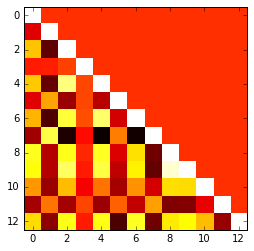

(22.463510392609702, 9.1122919626953554)
[(3.6003693533487291, 8.8092358152425732), (11.672055427251733, 23.702005443779942), (11.1294688221709, 6.8504386632910554), (0.069284064665127015, 0.25393657288505234), (0.55417020785219395, 0.11622302091448138), (6.2732540415704383, 0.68935132017153189), (68.233487297921471, 28.262992247723403), (3.8094390300230949, 2.118212980310223), (9.5519630484988447, 8.698050116153329), (407.74133949191685, 168.4609660040804), (18.474364896073901, 2.1520308096960128), (354.59258660508084, 94.022245727768322), (12.689076212471134, 7.1090877062374807)]
('CRIM', Target) COV=0  COR=0
('ZN', Target) COV=-1.137e-13  COR=-5.264e-16
('INDUS', Target) COV=5.684e-14  COR=9.106e-16
('CHAS', Target) COV=-2.22e-16  COR=-9.596e-17
('NOX', Target) COV=-1.776e-15  COR=-1.677e-15
('RM', Target) COV=-2.842e-14  COR=-4.525e-15
('AGE', Target) COV=0  COR=0
('DIS', Target) COV=-1.421e-14  COR=-7.362e-16
('RAD', Target) COV=2.842e-14  COR=3.586e-16
('TAX', Target) COV=0  COR=

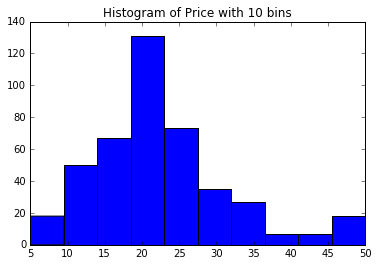

Histogram


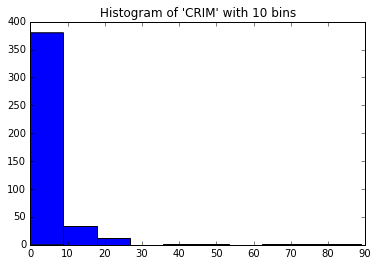

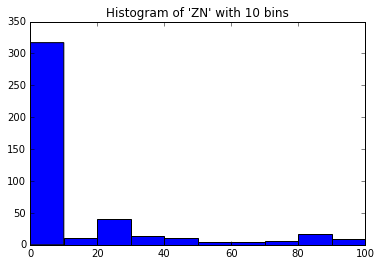

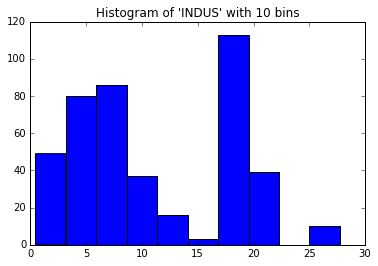

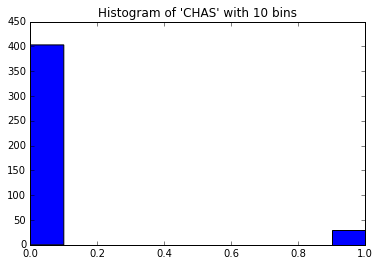

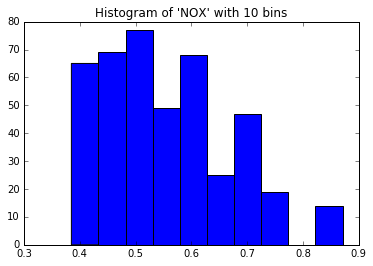

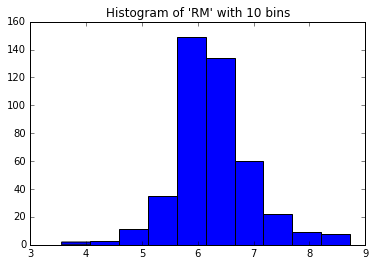

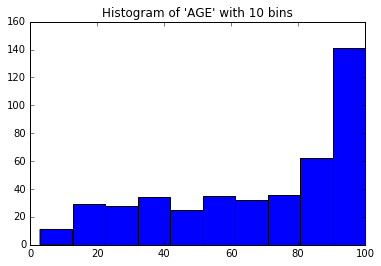

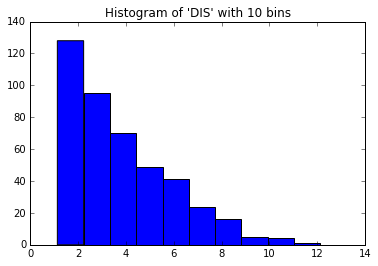

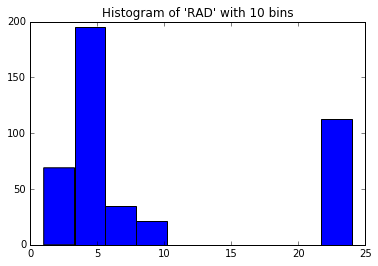

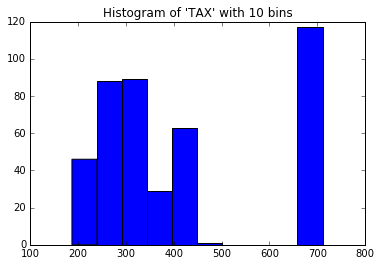

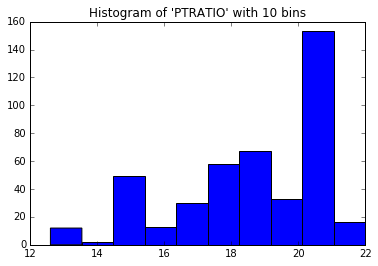

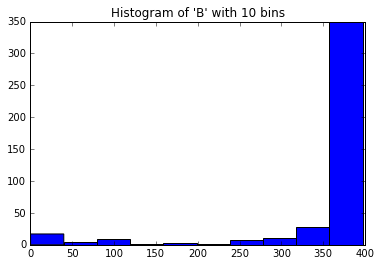

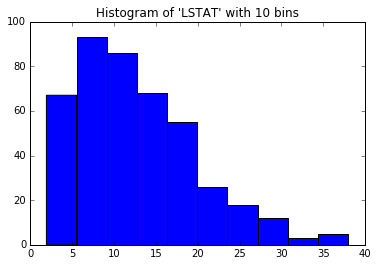

In [5]:
n_attrs = trainX.shape[1]
attrs = [ trainX[:, i] for i in range(n_attrs)]
distribs = [(a.mean(), a.std())for a in attrs]


corrs = np.zeros(shape=(n_attrs, n_attrs))
for i, a in enumerate(attrs):
    for j in range(0, i + 1):
        b = attrs[j]
        # COV[A,B] = E[X - muX] E[Y - muY] = E[XY] - E[X]E[Y]
        # Pearson CORR[A, B] = COV[A,B] / (sigmaX * sigmaY)
        cov_ab = np.multiply(a, b).mean() - distribs[i][0] * distribs[j][0]
        cor_ab = cov_ab / (distribs[i][1] * distribs[j][1])
        corrs[i][j] = cor_ab

print("Correlations between the attributes")
print(pd.DataFrame(corrs))
plt.imshow(corrs, cmap='hot', interpolation='nearest')
plt.show()

# Correlation between the attribs and target value
target_distrib = (trainY.mean(), trainY.std())
print(target_distrib)
print(distribs)
for i, attr in enumerate(attrs):
    mean_ab = np.multiply(trainY, attr).mean()
    cov_ab = mean_ab - target_distrib[0] * distribs[i][0]
    cor_ab = cov_ab / (target_distrib[1] * distribs[i][1])
    print("('%s', Target) COV=%.4g  COR=%.4g" % (boston.feature_names[i] , cov_ab, cor_ab))
    #print(mean_ab, target_distrib[0], distribs[i][0], cov_ab, cor_ab)

bins = 10
plt.hist(trainY, bins=bins)
plt.title("Histogram of Price with %d bins" % bins)
plt.show()


print("Histogram")
for i, attr in enumerate(attrs):
    plt.hist(attr, bins=bins)
    plt.title("Histogram of '%s' with %d bins" % (boston.feature_names[i], bins))
    plt.show()


# 2 Linear Regression

In [12]:
def predict(X, W):
    return np.matmul(X, W)

def MSECost(Y2, Y1):
    # Cost      = 1/N  SIGMA[(XW-Y)^2]
    return float(np.sum((Y2 - Y1) ** 2) / len(Y2))

def gradient_desc(X, Y, W, alpha,
                  num_iter = 1000, conv_tol=0.01, print_interval = 500):
    c = float('inf')
    print("Learn Rate", alpha)
    for i in range(num_iter):
        # 
        # delta =  2/N SIGMA[(XW - Y)*x]
        predY = predict(X, W)
        diff = predY - Y
        delta = np.sum(np.multiply(X, diff), axis=0) # sum top to bottom for each attribute
        delta  = delta * 2.0 / len(Y)
        delta = np.array([delta]).transpose()        # restore vector shape of (n_attr x 1)
        
        W = (W - alpha * delta)
        if i % print_interval == 0:
            predY = predict(X, W)
            #print(np.concatenate((Y, predY), axis=1))
            newcost = MSECost(predY, Y)
            print("#%d, cost = %.8g" % (i, newcost))
            if np.isnan(newcost) or np.isinf(newcost) or np.isneginf(newcost):
                raise Exception("ERROR: number overflow, please adjust learning rate")
            diff = abs(newcost - c)
            c = newcost
            if diff < conv_tol:
                print("Converged with tolerance %f " % conv_tol)
                break            
        if i % (print_interval * 10) == 0:
            print(W.flatten())
    return W


# compute means and stds
class LinearRegression(object):
    
    def __init__(self, X, Y, learn_rate=0.001, num_iter=1000, conv_tol=0.1):
        
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)        
        X = self.normalize(X)
        self.n_attrs = X.shape[1]
        W = np.random.rand(self.n_attrs, 1)
        self.W = gradient_desc(X, Y, W, alpha=learn_rate,
                                num_iter=num_iter, conv_tol=conv_tol)
    
    def normalize(self, X):
        X = (X - self.means) / self.stds
        # Bias is added as a weight to simplify the calculations
        X = np.insert(X, 0, 1, axis=1)
        return X
    
    def predict(self, X, normalize=True):
        if normalize:
            X = self.normalize(X)
        return np.matmul(X, self.W)
            
    
alpha = 0.001
conv_tol = 0.0001
num_iter = 50000
linreg = LinearRegression(trainX, trainY, alpha, num_iter, conv_tol)


print("\n\n")
predY = linreg.predict(trainX)
train_mse_cost = MSECost(predY, trainY)
print('Train MSE::', train_mse_cost)


predY = linreg.predict(testX)
test_mse_cost = MSECost(predY, testY)
print('Test MSE::', test_mse_cost)

Learn Rate 0.001
#0, cost = 588.87457
[ 0.57537021  0.73225509  0.25818169  0.29533326  0.12634616  0.23675618
  0.87647097  0.6901627   0.05071413  0.19866864  0.9557848   0.28114369
  0.31251364  0.64726583]
#500, cost = 90.949911
#1000, cost = 32.102874
#1500, cost = 23.697875
#2000, cost = 22.239699
#2500, cost = 21.823993
#3000, cost = 21.61461
#3500, cost = 21.475477
#4000, cost = 21.374314
#4500, cost = 21.298028
#5000, cost = 21.239152
[ 22.46252657  -0.8329358    0.75308182  -0.55436301   1.00636635
  -1.20955484   2.95295406  -0.3693307   -2.72621215   1.21445233
  -0.6181108   -1.78886358   0.84521754  -3.56477062]
#5500, cost = 21.192844
#6000, cost = 21.155811
#6500, cost = 21.125752
#7000, cost = 21.10103
#7500, cost = 21.080461
#8000, cost = 21.063174
#8500, cost = 21.04852
#9000, cost = 21.036006
#9500, cost = 21.025254
#10000, cost = 21.015968
[ 22.46351035  -0.91635994   0.94232664  -0.42180723   0.96221778
  -1.50883552   2.78803997  -0.31899633  -3.06980661   1.8321

# Ridge Regression

In [31]:

def MSECost_ridge(X, W, Y, lambd):
    # Cost      = 1/N  \SIGMA[(XW-Y)^2] + lambd W||_2^2
    predY = predict(X, W)
    cost = float(np.sum((predY - Y) ** 2)) / len(Y)
    cost += lambd * np.sum((W) ** 2)
    return cost

def gradient_desc_ridge(X, Y, W, alpha, lambd,
                  num_iter = 1000, conv_tol=0.01, print_interval = 500):
    c = float('inf')
    print("Learn Rate", alpha)
    for i in range(num_iter):
        # 
        # delta =  2/N SIGMA[(XW - Y)*x] + 2 * \lambd * W
        diff = predict(X, W) - Y
        delta = np.sum(np.multiply(X, diff), axis=0) # sum top to bottom for each attribute
        delta = delta * 2.0 / len(Y)
        delta = np.array([delta]).transpose()        # restore vector shape of (n_attr x 1)
        delta  = delta + (2 * lambd * W)           # Vectors addition

        W = (W - alpha * delta)
        if i % print_interval == 0:
            predY = predict(X, W)
            #print(np.concatenate((Y, predY), axis=1))
            newcost = MSECost_ridge(X, W, Y, lambd)
            print("#%d, cost = %.8g" % (i, newcost))
            if np.isnan(newcost) or np.isinf(newcost) or np.isneginf(newcost):
                raise Exception("ERROR: number overflow, please adjust learning rate")
            diff = abs(newcost - c)
            c = newcost
            if diff < conv_tol:
                print("Converged with tolerance %f " % conv_tol)
                break            
        if i % (print_interval * 10) == 0:
            print(W.flatten())
    return W


# compute means and stds
class RidgeRegression(object):
    
    def __init__(self, X, Y, learn_rate=0.001, lambd=0.1, num_iter=1000, conv_tol=0.1):
        
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)        
        X = self.normalize(X)
        self.n_attrs = X.shape[1]
        W = np.random.rand(self.n_attrs, 1)
        self.lambd = lambd
        self.W = gradient_desc_ridge(X, Y, W, alpha=learn_rate, lambd=lambd,
                                num_iter=num_iter, conv_tol=conv_tol)
    
    def normalize(self, X):
        X = (X - self.means) / self.stds
        # Bias is added as a weight to simplify the calculations
        X = np.insert(X, 0, 1, axis=1)
        return X
    
    def predict(self, X, normalize=True):
        if normalize:
            X = self.normalize(X)
        return np.matmul(X, self.W)
    
    def find_cost(self, X, Y, lambd=None, normalize=True):
        if lambd is None:
            lambd = self.lambd
        predY = self.predict(X, normalize)
        return MSECost_ridge(X, self.W, Y, lambd)
    
alpha = 0.001
conv_tol = 0.0001
num_iter = 100000
lambd = 0.1
ridreg = RidgeRegression(trainX, trainY, alpha, lambd, num_iter, conv_tol)

print("\n\n")
train_mse_cost = ridreg.find_cost(trainX, trainY, lambd=lambd)
print('Train MSE::', train_mse_cost)


test_mse_cost = ridreg.find_cost(testX, testY, lambd=lambd)
print('Test MSE::', test_mse_cost)

Learn Rate 0.001
#0, cost = 587.53036
[ 0.66405001  0.19501704  0.01705566  0.35679773  0.55313872  0.90925823
  0.93887899  0.87426569  0.41548304  0.07668756  0.54719381  0.74979983
  0.6966644   0.87311953]
#500, cost = 122.56215
#1000, cost = 77.56625
#1500, cost = 72.088593
#2000, cost = 71.204223
#2500, cost = 70.953292
#3000, cost = 70.838771
#3500, cost = 70.775515
#4000, cost = 70.738308
#4500, cost = 70.715777
#5000, cost = 70.701852
[ 20.42104708  -0.74920548   0.61907985  -0.53348841   0.98471338
  -0.84201909   2.89842771  -0.35411962  -2.04967441   0.87802192
  -0.59309002  -1.64350654   0.80515487  -3.2022988 ]
#5500, cost = 70.693093
#6000, cost = 70.687496
#6500, cost = 70.683864
#7000, cost = 70.681475
#7500, cost = 70.679883
#8000, cost = 70.678809
#8500, cost = 70.678077
#9000, cost = 70.677574
#9500, cost = 70.677225
#10000, cost = 70.676981
[ 20.42137308  -0.77506567   0.67658047  -0.49590519   0.97122264
  -0.96383167   2.84058388  -0.33256114  -2.17230826   1.05

ValueError: shapes (433,13) and (14,1) not aligned: 13 (dim 1) != 14 (dim 0)

In [ ]:
np.multiply(trainX[:, 1], trainX[:, 1])
